# DX 704 Week 3 Project

This week's project will give you practice with optimizing choices for bandit algorithms.
You will be given access to the bandit problem via a blackbox object, and you will investigate the bandit rewards to pick a suitable algorithm.

The full project description, a template notebook and supporting code are available on GitHub: [Project 3 Materials](https://github.com/bu-cds-dx704/dx704-project-03).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Pick a Bandit Algorithm

Experiment with the multi-armed bandit interface using seed 0 to learn about the distribution of rewards and decide what kind of bandit algorithm will be appropriate.
A histogram will likely be helpful.

In [49]:
import sys
!{sys.executable} -m pip install numpy


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [50]:
import sys
!{sys.executable} -m pip install numpy matplotlib



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [51]:
# DO NOT CHANGE

import numpy as np

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x


In [52]:
bandit0 = BanditProblem(0)

In [53]:
bandit0.get_num_arms()

3

In [54]:
bandit0.get_reward(arm=0)

1.8255111545554434

arm = 0 min = 0.0 mean = 0.8283991493980221 max = 6.782465988716871
arm = 1 min = 0.0 mean = 0.6295542843652631 max = 3.973415112470378
arm = 2 min = 0.0 mean = 0.8914242189789551 max = 4.738118687959142


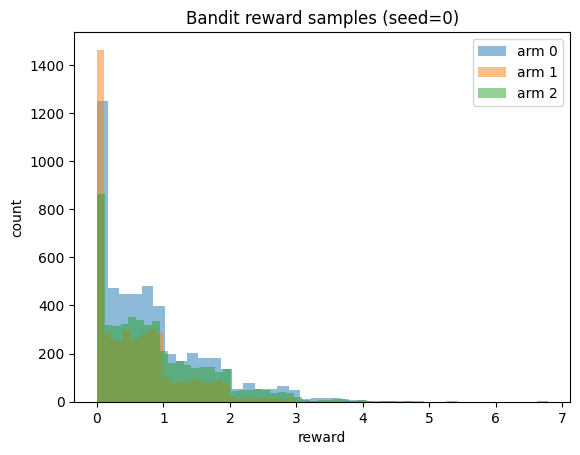

In [55]:
import matplotlib.pyplot as plt

bandit0 = BanditProblem(0)
K = bandit0.get_num_arms()

# collect samples per arm
num_samples = 5000
samples = []

for arm in range(K):
    arm_rewards = [bandit0.get_reward(arm) for _ in range(num_samples)]
    samples.append(np.array(arm_rewards))

# quick numeric summary
for arm in range(K):
    print("arm =", arm,
          "min =", samples[arm].min(),
          "mean =", samples[arm].mean(),
          "max =", samples[arm].max())

# histogram per arm
plt.figure()
for arm in range(K):
    plt.hist(samples[arm], bins=40, alpha=0.5, label="arm " + str(arm))
plt.legend()
plt.title("Bandit reward samples (seed=0)")
plt.xlabel("reward")
plt.ylabel("count")
plt.show()


Based on your investigation, pick an appropriate bandit algorithm to implement from the algorithms covered this week.
Write a file "algorithm-choice.txt" that states your choice and give a single sentence justifying your choice and rejecting the alternatives.
Keep your explanation concise; you should be able to justify your choice solely based on the type of numbers observed, and whether those match the bandit algorithms that you have learned.

## Part 2: Implement Bandit

Based on your decision, implement an appropriate bandit algorithm and pick 1000 actions using seed 2026.

In [56]:
bandit = BanditProblem(2026)
K = bandit.get_num_arms()
T = 1000

# Scale [0,1] for UCB1
c = 10.0

counts = np.zeros(K, dtype=int)      # number of pulls per arm
sum_scaled = np.zeros(K, dtype=float)  # sum of (reward/c) per arm

history_actions = []
history_rewards = []

for arm in range(K):
    r = bandit.get_reward(arm)
    history_actions.append(arm)
    history_rewards.append(r)
    counts[arm] = counts[arm] + 1
    sum_scaled[arm] = sum_scaled[arm] + (r / c)

for t in range(K + 1, T + 1):
    means = sum_scaled / counts
    bonus = np.sqrt((2.0 * np.log(t)) / counts)
    ucb = means + bonus

    arm = int(np.argmax(ucb))

    r = bandit.get_reward(arm)
    history_actions.append(arm)
    history_rewards.append(r)

    counts[arm] = counts[arm] + 1
    sum_scaled[arm] = sum_scaled[arm] + (r / c)


Write a file "history.tsv" with columns action and reward in the order that the actions were taken.

In [57]:
with open("history.tsv", "w") as f:
    f.write("action\treward\n")
    for a, r in zip(history_actions, history_rewards):
        f.write(str(a) + "\t" + str(r) + "\n")

print("history.tsv written with " + str(len(history_actions)) + " rows")

history.tsv written with 1000 rows


Submit "history.tsv" in Gradescope.

## Part 3: Action Statistics

Based on the data from part 2, estimate the expected reward for each arm and write a file "actions.tsv" with the columns action, min_reward, mean_reward, max_reward.

In [58]:
# Read history.tsv manually
actions = []
rewards = []

with open("history.tsv", "r") as f:
    next(f)  # skip header
    for line in f:
        a, r = line.strip().split("\t")
        actions.append(int(a))
        rewards.append(float(r))

actions = np.array(actions)
rewards = np.array(rewards)

K = int(np.max(actions)) + 1

# Write actions.tsv
with open("actions.tsv", "w") as f:
    f.write("action\tmin_reward\tmean_reward\tmax_reward\n")

    for arm in range(K):
        arm_rewards = rewards[actions == arm]

        min_r = float(np.min(arm_rewards))
        mean_r = float(np.mean(arm_rewards))
        max_r = float(np.max(arm_rewards))

        f.write(
            str(arm) + "\t" +
            str(min_r) + "\t" +
            str(mean_r) + "\t" +
            str(max_r) + "\n"
        )

print("actions.tsv written")


actions.tsv written


Submit "actions.tsv" in Gradescope.

## Part 4: Regret Estimates

Estimate the regret taking 1000 actions with the following strategies.

* uniform: Pick an arm uniformly at random.
* just-i: Always pick arm $i$. Do this for $i=0$ to $K-1$ where $K$ is the number of arms.
* actual: This should match your output in part 2.

These estimates should be based on your previous action statistics; you should not use the true action values from the bandit code.

In [59]:
# mean rewards (mu_hat) from actions.tsv
mu_hat = []
with open("actions.tsv", "r") as f:
    next(f)  # skip header
    for line in f:
        parts = line.strip().split("\t")
        mu_hat.append(float(parts[2]))  # mean_reward column

mu_hat = np.array(mu_hat)
K = len(mu_hat)

# read actions from history.tsv
actions = []
with open("history.tsv", "r") as f:
    next(f)  # skip header
    for line in f:
        a = int(line.strip().split("\t")[0])
        actions.append(a)

actions = np.array(actions)
T = len(actions)

# benchmark = always pick best estimated arm
B = T * np.max(mu_hat)

# uniform expected reward
uniform_regret = B - (T * np.mean(mu_hat))

# just-i regrets
just_regrets = []
for i in range(K):
    just_regrets.append(B - (T * mu_hat[i]))

actual_expected = np.sum(mu_hat[actions])
actual_regret = B - actual_expected



Write your results to a file "strategies.tsv" with the columns strategy and regret.

In [60]:
# write strategies.tsv
with open("strategies.tsv", "w") as f:
    f.write("strategy\tregret\n")
    f.write("uniform\t" + str(uniform_regret) + "\n")
    for i in range(K):
        f.write("just-" + str(i) + "\t" + str(just_regrets[i]) + "\n")
    f.write("actual\t" + str(actual_regret) + "\n")

Submit "strategies.tsv" in Gradescope.

## Part 5: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

## Part 6: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.

Submit "project.ipynb" in Gradescope.